In [2]:
import matplotlib.pyplot as plt

import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


In [14]:
import cv2
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

# Load reference images
scene_name = 'head1'
ref_dir = f"/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/data_kiwi_soap/realdata/{scene_name}/exr_ref"
list_refs = []
for i in range(len(os.listdir(ref_dir))):
    img_pth = f"{ref_dir}/{i}.exr"
    img = cv2.imread(img_pth,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    list_refs.append(img)

filename = f"./scene/croissant1_out.xml"
scene = mi.load_file(filename)
params = mi.traverse(scene)
for key,value in params.items():
    if key.startswith('sensor') and key.endswith('film.size'):
        params[key] = (512,512)
        # print(value)

sensors = scene.sensors()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


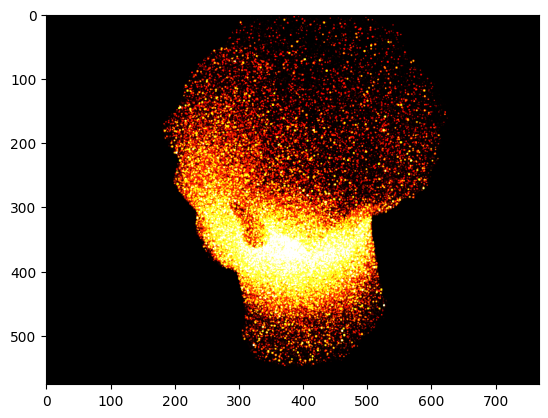

In [15]:
sensor_idx = 0
sensor_idx = 1

plt.close()
img = mi.render(scene, params, sensor=1, spp=spp, seed=it)
plt.imshow(img)

In [32]:
# params = mi.traverse(scene)

key_sig = 'OBJMesh.interior_medium.sigma_t.value.value'
key_alb = 'OBJMesh.interior_medium.albedo.value.value'

opt = mi.ad.Adam(lr=0.02)
opt[key_sig] = params[key_sig]
opt[key_alb] = params[key_alb]
params.update(opt)

sensor_count = len(os.listdir(ref_dir))
iteration_count = 300
spp = 8

In [ ]:
from tqdm import tqdm

for it in tqdm(range(iteration_count)):
    total_loss = 0.0
    for sensor_idx in range(sensor_count):
        # Perform the differentiable light transport simulation
        # img = mi.render(scene, params, sensor=sensors[sensor_idx], spp=spp, seed=it)
        img = mi.render(scene, params, sensor=sensor_idx, spp=spp, seed=it)

        # L2 loss function
        loss = dr.mean(dr.sqr(img - list_refs[sensor_idx]))

        # Backpropagate gradients
        dr.backward(loss)

        # Take a gradient step
        opt.step()

        # Clamp the optimized density values. Since we used the `scale` parameter
        # when instantiating the volume, we are in fact optimizing extinction
        # in a range from [1e-6 * scale, scale].
        opt[key_sig] = dr.clamp(opt[key_sig], 1e-6, 1.0)
        opt[key_alb] = dr.clamp(opt[key_alb], 1e-6, 1.0)

        # Propagate changes to the scene
        params.update(opt)

        total_loss += loss[0]
        # print(opt[key_sig])
        # print(opt[key_alb])
    tqdm.write(f"Iteration {it:02d}: error={total_loss:6f}", end='\r')

  0%|▎                                                                                                             | 1/300 [00:43<3:36:04, 43.36s/it]

  1%|▋                                                                                                             | 2/300 [01:28<3:39:52, 44.27s/it]

  1%|█                                                                                                             | 3/300 [02:14<3:43:36, 45.17s/it]

  1%|█▍                                                                                                            | 4/300 [02:57<3:39:10, 44.43s/it]

  2%|█▊                                                                                                            | 5/300 [03:43<3:39:48, 44.71s/it]

  2%|██▏                                                                                                           | 6/300 [04:25<3:35:05, 43.90s/it]

  2%|██▌                                                                                                           | 7/300 [05:07<3:31:07, 43.23s/it]

  3%|██▉                                                                                                           | 8/300 [05:48<3:27:33, 42.65s/it]

  3%|███▎                                                                                                          | 9/300 [06:28<3:23:22, 41.93s/it]

  3%|███▋                                                                                                         | 10/300 [07:09<3:20:28, 41.48s/it]

  4%|███▉                                                                                                         | 11/300 [07:50<3:18:33, 41.22s/it]

  4%|████▎                                                                                                        | 12/300 [08:30<3:16:37, 40.96s/it]

  4%|████▋                                                                                                        | 13/300 [09:10<3:15:20, 40.84s/it]

  5%|█████                                                                                                        | 14/300 [09:51<3:14:19, 40.77s/it]

  5%|█████▍                                                                                                       | 15/300 [10:31<3:12:44, 40.58s/it]

  5%|█████▊                                                                                                       | 16/300 [11:11<3:11:23, 40.43s/it]

  6%|██████▏                                                                                                      | 17/300 [11:52<3:10:33, 40.40s/it]

  6%|██████▌                                                                                                      | 18/300 [12:32<3:09:09, 40.25s/it]

  6%|██████▉                                                                                                      | 19/300 [13:12<3:08:22, 40.22s/it]

  7%|███████▎                                                                                                     | 20/300 [13:52<3:08:20, 40.36s/it]

  7%|███████▋                                                                                                     | 21/300 [14:34<3:09:01, 40.65s/it]

  7%|███████▉                                                                                                     | 22/300 [15:14<3:07:19, 40.43s/it]

  8%|████████▎                                                                                                    | 23/300 [15:54<3:06:09, 40.32s/it]

  8%|████████▋                                                                                                    | 24/300 [16:34<3:05:00, 40.22s/it]

  8%|█████████                                                                                                    | 25/300 [17:14<3:04:38, 40.29s/it]

  9%|█████████▍                                                                                                   | 26/300 [17:54<3:04:00, 40.29s/it]

  9%|█████████▊                                                                                                   | 27/300 [18:35<3:03:46, 40.39s/it]

  9%|██████████▏                                                                                                  | 28/300 [19:17<3:04:46, 40.76s/it]

 10%|██████████▌                                                                                                  | 29/300 [19:57<3:03:40, 40.67s/it]

 10%|██████████▉                                                                                                  | 30/300 [20:37<3:02:37, 40.58s/it]

 10%|███████████▎                                                                                                 | 31/300 [21:18<3:01:46, 40.55s/it]

 11%|███████████▋                                                                                                 | 32/300 [22:01<3:04:24, 41.29s/it]

 11%|███████████▉                                                                                                 | 33/300 [22:44<3:06:25, 41.89s/it]

 11%|████████████▎                                                                                                | 34/300 [23:28<3:08:03, 42.42s/it]

 12%|████████████▋                                                                                                | 35/300 [24:11<3:08:27, 42.67s/it]

 12%|█████████████                                                                                                | 36/300 [24:56<3:10:06, 43.21s/it]

 12%|█████████████▍                                                                                               | 37/300 [25:37<3:07:24, 42.76s/it]

 13%|█████████████▊                                                                                               | 38/300 [26:16<3:01:04, 41.47s/it]

 13%|██████████████▏                                                                                              | 39/300 [26:54<2:56:13, 40.51s/it]

 13%|██████████████▌                                                                                              | 40/300 [27:32<2:51:57, 39.68s/it]

 14%|██████████████▉                                                                                              | 41/300 [28:10<2:49:02, 39.16s/it]

 14%|███████████████▎                                                                                             | 42/300 [28:48<2:47:17, 38.90s/it]

 14%|███████████████▌                                                                                             | 43/300 [29:26<2:45:57, 38.74s/it]

 15%|███████████████▉                                                                                             | 44/300 [30:04<2:44:25, 38.54s/it]

 15%|████████████████▎                                                                                            | 45/300 [30:44<2:44:59, 38.82s/it]

 15%|████████████████▋                                                                                            | 46/300 [31:24<2:46:01, 39.22s/it]

 16%|█████████████████                                                                                            | 47/300 [32:06<2:48:14, 39.90s/it]

 16%|█████████████████▍                                                                                           | 48/300 [32:47<2:49:24, 40.34s/it]

 16%|█████████████████▊                                                                                           | 49/300 [33:27<2:48:52, 40.37s/it]

 17%|██████████████████▏                                                                                          | 50/300 [34:08<2:48:23, 40.41s/it]

 17%|██████████████████▌                                                                                          | 51/300 [34:47<2:46:26, 40.11s/it]

 17%|██████████████████▉                                                                                          | 52/300 [35:26<2:43:42, 39.61s/it]

 18%|███████████████████▎                                                                                         | 53/300 [36:06<2:43:22, 39.69s/it]

 18%|███████████████████▌                                                                                         | 54/300 [36:45<2:42:42, 39.68s/it]

 18%|███████████████████▉                                                                                         | 55/300 [37:24<2:40:43, 39.36s/it]

 19%|████████████████████▎                                                                                        | 56/300 [38:03<2:40:14, 39.40s/it]

 19%|████████████████████▋                                                                                        | 57/300 [38:44<2:40:25, 39.61s/it]

 19%|█████████████████████                                                                                        | 58/300 [39:23<2:39:19, 39.50s/it]

 20%|█████████████████████▍                                                                                       | 59/300 [40:02<2:38:56, 39.57s/it]

 20%|█████████████████████▊                                                                                       | 60/300 [40:42<2:37:57, 39.49s/it]

 20%|██████████████████████▏                                                                                      | 61/300 [41:21<2:37:27, 39.53s/it]

 21%|██████████████████████▌                                                                                      | 62/300 [42:02<2:38:00, 39.84s/it]

 21%|██████████████████████▉                                                                                      | 63/300 [42:43<2:38:26, 40.11s/it]

 21%|███████████████████████▎                                                                                     | 64/300 [43:23<2:38:32, 40.31s/it]

 22%|███████████████████████▌                                                                                     | 65/300 [44:04<2:37:52, 40.31s/it]

 22%|███████████████████████▉                                                                                     | 66/300 [44:43<2:36:19, 40.08s/it]

 22%|████████████████████████▎                                                                                    | 67/300 [45:24<2:35:52, 40.14s/it]

 23%|████████████████████████▋                                                                                    | 68/300 [46:03<2:34:37, 39.99s/it]

 23%|█████████████████████████                                                                                    | 69/300 [46:43<2:33:08, 39.78s/it]

 23%|█████████████████████████▍                                                                                   | 70/300 [47:22<2:31:49, 39.61s/it]

 24%|█████████████████████████▊                                                                                   | 71/300 [48:01<2:31:11, 39.61s/it]

 24%|██████████████████████████▏                                                                                  | 72/300 [48:42<2:31:14, 39.80s/it]

 24%|██████████████████████████▌                                                                                  | 73/300 [49:23<2:32:09, 40.22s/it]

 25%|██████████████████████████▉                                                                                  | 74/300 [50:02<2:30:37, 39.99s/it]

 25%|███████████████████████████▎                                                                                 | 75/300 [50:42<2:29:17, 39.81s/it]

 25%|███████████████████████████▌                                                                                 | 76/300 [51:21<2:28:11, 39.70s/it]

 26%|███████████████████████████▉                                                                                 | 77/300 [52:00<2:26:48, 39.50s/it]

 26%|████████████████████████████▎                                                                                | 78/300 [53:11<3:00:30, 48.78s/it]

 26%|████████████████████████████▋                                                                                | 79/300 [54:16<3:18:07, 53.79s/it]

 27%|█████████████████████████████                                                                                | 80/300 [54:56<3:01:29, 49.50s/it]

 27%|█████████████████████████████▍                                                                               | 81/300 [55:36<2:50:47, 46.79s/it]

In [23]:
img.shape

(512, 512, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


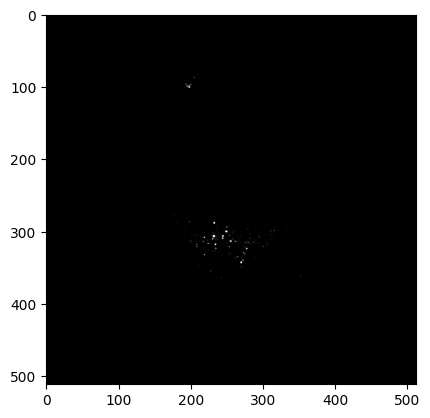

In [31]:
plt.imshow(img)

In [25]:
params

SceneParameters[
  --------------------------------------------------------------------------------------------------
  Name                                           Flags    Type  Parent
  --------------------------------------------------------------------------------------------------
  HDRFilm.size                                            ScalarVector2u HDRFilm
  HDRFilm.crop_size                                       ScalarVector2u HDRFilm
  HDRFilm.crop_offset                                     ScalarPoint2u HDRFilm
  point-light.position                                    Point3f PointLight
  point-light.intensity.value                    ∂        Color3f SRGBReflectanceSpectrum
  OBJMesh.interior_medium.scale                           float HomogeneousMedium
  OBJMesh.interior_medium.albedo.value.value     ∂        Color3f SRGBReflectanceSpectrum
  OBJMesh.interior_medium.sigma_t.value.value    ∂        Color3f SRGBReflectanceSpectrum
  OBJMesh.interior_medium.phase_functio